In [2]:
%pip install scikit-image

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



                                              0.0/24.5 MB ? eta -:--:--
                                              0.1/24.5 MB 1.7 MB/s eta 0:00:15
                                              0.2/24.5 MB 3.0 MB/s eta 0:00:09
                                              0.5/24.5 MB 4.2 MB/s eta 0:00:06
     -                                        0.9/24.5 MB 5.0 MB/s eta 0:00:05
     --                                       1.8/24.5 MB 7.9 MB/s eta 0:00:03
     ------                                   3.7/24.5 MB 13.1 MB/s eta 0:00:02
     ----------                               6.5/24.5 MB 19.7 MB/s eta 0:00:01
     -----------                              7.0/24.5 MB 21.4 MB/s eta 0:00:01
     -----------                              7.0/24.5 MB 21.4 MB/s eta 0:00:01
     -----------                              7.3/24.5 MB 16.7 MB/s eta 0:00:02
     ----------------                        10.2/24.5 MB 19.8 MB/s eta 0:00:01
     -------------------                     12.4/24

Install Dependencies

In [251]:
import numpy as np
from PIL import Image
from scipy.fftpack import dct, idct, dctn
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import cv2


In [ ]:
QP = 10

Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

Helperfunctions for showing images

In [261]:
def show_image(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

def show_image_side_by_side(img1, img2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1)
    ax1.axis('off')
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    ax2.axis('off')
    plt.show()

Open the image and convert it to YUV

In [187]:
#Read in test image from assets/test.png and convert to YUV
img = Image.open('assets/test.png')
# Convert the image to YUV
img_yuv = img.convert('YCbCr')


Decrease the resolution of the chroma data to decrease filesize

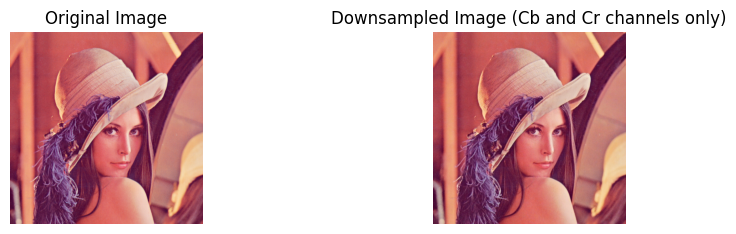

In [262]:
downsampling_factor = 3 # Adjust as needed

# Extract Y, Cb, and Cr channels
y, cb, cr = cv2.split(np.array(img_yuv))

# Downsample Cb and Cr channels
cb_downsampled = cv2.resize(cb, (cb.shape[1] // downsampling_factor, cb.shape[0] // downsampling_factor),
                            interpolation=cv2.INTER_LINEAR)
cr_downsampled = cv2.resize(cr, (cr.shape[1] // downsampling_factor, cr.shape[0] // downsampling_factor),
                            interpolation=cv2.INTER_LINEAR)

# Ensure the downsampled Cb and Cr channels have the same size as the original channels
cb_downsampled = cv2.resize(cb_downsampled, (y.shape[1], y.shape[0]), interpolation=cv2.INTER_LINEAR)
cr_downsampled = cv2.resize(cr_downsampled, (y.shape[1], y.shape[0]), interpolation=cv2.INTER_LINEAR)

# Merge the downsampled Cb and Cr channels with the original Y channel
downsampled_yuv = cv2.merge([y, cb_downsampled, cr_downsampled])

# Convert back to PIL Image
downsampled_img = Image.fromarray(downsampled_yuv, mode='YCbCr')

show_image_side_by_side(img, downsampled_img, 'Original Image', 'Downsampled Image (Cb and Cr channels only)')



In [277]:
def split_and_center(channel):
    h, w = channel.shape
    # Calculate padding needed for both dimensions
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8

    # Pad the image
    padded_channel = np.pad(channel, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

    # Split the padded image into 8x8 pixel chunks
    blocks = [padded_channel[i:i+8, j:j+8] for i in range(0, padded_channel.shape[0], 8) for j in range(0, padded_channel.shape[1], 8)]

    # Center values around 0 by using int8 type
    centered_blocks = [np.int8(block - 128) for block in blocks]

    return centered_blocks

# Extract Y, Cb, and Cr channels
y, cb, cr = cv2.split(np.array(img_yuv))

# Apply the modified function
y_blocks_centered = split_and_center(y)
cb_blocks_centered = split_and_center(cb)
cr_blocks_centered = split_and_center(cr)

# Display the first block for every channel and the original block
# show_image_side_by_side(y_blocks_centered[0], y_blocks_centered[0] + 128, 'Centered Y block', 'Original Y block')
# show_image_side_by_side(cb_blocks_centered[0], cb_blocks_centered[0] + 128, 'Centered Cb block', 'Original Cb block')
# show_image_side_by_side(cr_blocks_centered[0], cr_blocks_centered[0] + 128, 'Centered Cr block', 'Original Cr block')

In [279]:
# Apply DCT to the blocks
y_blocks_dct = [dct(block, norm='ortho') for block in y_blocks_centered]
cb_blocks_dct = [dct(block, norm='ortho') for block in cb_blocks_centered]
cr_blocks_dct = [dct(block, norm='ortho') for block in cr_blocks_centered]

# Display the first block for every channel and the original block
# show_image_side_by_side(y_blocks_dct[0], y_blocks_centered[0], 'DCT Y block', 'Original Y block')
# show_image_side_by_side(cb_blocks_dct[0], cb_blocks_centered[0], 'DCT Cb block', 'Original Cb block')
# show_image_side_by_side(cr_blocks_dct[0], cr_blocks_centered[0], 'DCT Cr block', 'Original Cr block')

In [280]:
# Apply quantization to the blocks
y_blocks_quantized = [np.round(block / (Q * QP)) for block in y_blocks_dct]
cb_blocks_quantized = [np.round(block / (Q * QP)) for block in cb_blocks_dct]
cr_blocks_quantized = [np.round(block / (Q * QP)) for block in cr_blocks_dct]

# Display the first block for every channel and the original block
# show_image_side_by_side(y_blocks_quantized[0], y_blocks_dct[0], 'Quantized Y block', 'DCT Y block')
# show_image_side_by_side(cb_blocks_quantized[0], cb_blocks_dct[0], 'Quantized Cb block', 'DCT Cb block')
# show_image_side_by_side(cr_blocks_quantized[0], cr_blocks_dct[0], 'Quantized Cr block', 'DCT Cr block')

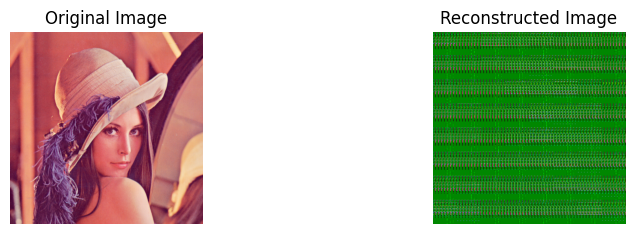

In [298]:
# Dequantization
y_blocks_dequantized = [block * (Q * QP) for block in y_blocks_quantized]
cb_blocks_dequantized = [block * (Q * QP) for block in cb_blocks_quantized]
cr_blocks_dequantized = [block * (Q * QP) for block in cr_blocks_quantized]

# Inverse DCT
y_blocks_idct = [idct(block, norm='ortho') for block in y_blocks_dequantized]
cb_blocks_idct = [idct(block, norm='ortho') for block in cb_blocks_dequantized]
cr_blocks_idct = [idct(block, norm='ortho') for block in cr_blocks_dequantized]

# Block assembly (assuming no padding needed)
y_reconstructed = np.zeros(y.shape)
cb_reconstructed = np.zeros(cb.shape)
cr_reconstructed = np.zeros(cr.shape)

for i in range(0, y.shape[0], 8):
    for j in range(0, y.shape[1], 8):
        y_reconstructed[i:i+8, j:j+8] = y_blocks_idct[(i // 8) * (y.shape[1] // 8) + (j // 8)]
        cb_reconstructed[i:i+8, j:j+8] = cb_blocks_idct[(i // 8) * (cb.shape[1] // 8) + (j // 8)]
        cr_reconstructed[i:i+8, j:j+8] = cr_blocks_idct[(i // 8) * (cr.shape[1] // 8) + (j // 8)]

# Inverse color space conversion (assuming no downsampling)
merged_yuv = cv2.merge([y_reconstructed, cb_reconstructed, cr_reconstructed])
reconstructed_img = Image.fromarray(merged_yuv, mode='YCbCr')
reconstructed_img = reconstructed_img.convert('RGB')  # Convert to RGB if needed

# Compare with the original image and calculate PSNR for evaluation
show_image_side_by_side(img, reconstructed_img, 'Original Image', 'Reconstructed Image')